## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

Сим Роман Дмитриевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

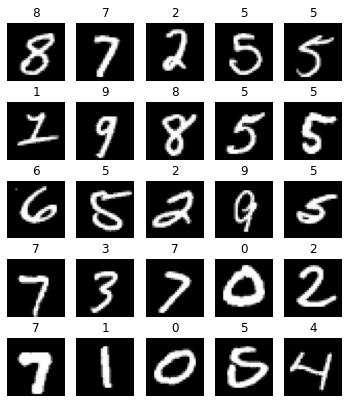

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
network = nn.Sequential(layer)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9972742795944214
backward 0.033665020018815994


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [8]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [9]:
def init_he(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)


init_func = init_he
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9972742795944214
forward 2.859571933746338
forward 3.8701236248016357
forward 6.167248249053955
forward 8.041150093078613
forward 8.464607238769531
forward 10.17035961151123
forward 12.732316017150879
forward 15.639808654785156
forward 8.587307929992676
forward 11.810242652893066
forward 17.45517921447754
forward 14.638630867004395
forward 19.80579948425293
forward 17.297090530395508
forward 14.56014633178711
forward 10.454488754272461
forward 13.223057746887207
forward 8.926915168762207
forward 7.342095375061035
forward 6.975790500640869
forward 9.41104507446289
forward 6.952357769012451
forward 6.093955993652344
forward 6.987386226654053
forward 3.453732490539551
forward 3.2895448207855225
forward 3.414858341217041
forward 3.545534372329712
forward 4.181499481201172
forward 2.9716286659240723
forward 2.7194507122039795
forward 4.056319713592529
backward 0.060378432273864746
backward 0.08041766285896301
backward 0.0923982784152031
backward 0.10002162307500839
backward 0.1088

In [10]:
def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

init_func = xavier
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9972742795944214
forward 0.8576235771179199
forward 0.5859848260879517
forward 0.42658331990242004
forward 0.34293806552886963
forward 0.24021989107131958
forward 0.10615768283605576
forward 0.08310434222221375
forward 0.06621167063713074
forward 0.050577953457832336
forward 0.03885885328054428
forward 0.027416376397013664
forward 0.019420191645622253
forward 0.013355477713048458
forward 0.010283240117132664
forward 0.008960571140050888
forward 0.0052626607939600945
forward 0.004153423476964235
forward 0.00277872197329998
forward 0.002341262297704816
forward 0.0020912429317831993
forward 0.0010917712934315205
forward 0.0007392113911919296
forward 0.0006143731880001724
forward 0.0006504534394480288
forward 0.00047271704534068704
forward 0.0005017658695578575
forward 0.000363598286639899
forward 0.00025330655626021326
forward 0.00015797158994246274
forward 0.00013658602256327868
forward 0.00014077556261327118
forward 0.00011325305240461603
backward 0.055136192589998245
backward

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [11]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight, requires_grad=False) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [12]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [13]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size_input, size_output))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: ReLU()
2: Dropout(p=0.5, inplace=False)
3: Linear(in_features=128, out_features=128, bias=True)
4: ReLU()
5: Dropout(p=0.5, inplace=False)
6: Linear(in_features=128, out_features=10, bias=True)
7: ReLU()


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.125/0.067	Accuracy: 0.963/0.978


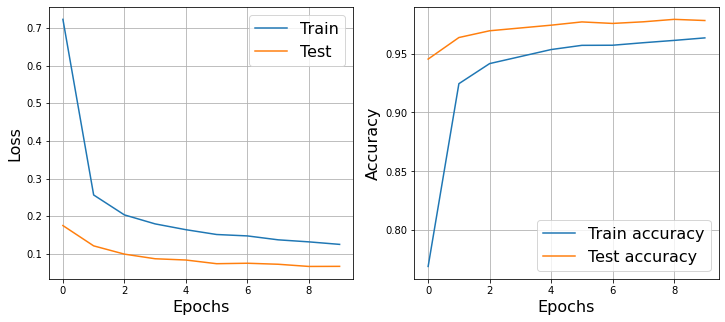

([0.7227476120376384,
  0.2565527342752353,
  0.2036684605199645,
  0.17977998179318047,
  0.1643957925011227,
  0.15162246868903959,
  0.14788064384844893,
  0.13750413605081502,
  0.1320787343277987,
  0.12541047346267872],
 [0.17533984124849114,
  0.12145994254682638,
  0.09952682029172967,
  0.08724179442366291,
  0.08389501073220863,
  0.07410474430439593,
  0.07534225045738718,
  0.07265255494703408,
  0.0668301964886015,
  0.06707844219488811],
 [0.7693008,
  0.9244292,
  0.9414923,
  0.9474392,
  0.95340264,
  0.9569785,
  0.9570674,
  0.9592051,
  0.9611652,
  0.9633029],
 [0.9453125,
  0.9636076,
  0.96934336,
  0.97171676,
  0.9740902,
  0.97685915,
  0.9755736,
  0.9769581,
  0.9790348,
  0.9780459])

In [15]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [16]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(DropConnect(size_input, size_output))
    layers.append(nn.ReLU())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: DropConnect(
  (linear): Linear(in_features=196, out_features=128, bias=True)
)
1: ReLU()
2: DropConnect(
  (linear): Linear(in_features=128, out_features=128, bias=True)
)
3: ReLU()
4: DropConnect(
  (linear): Linear(in_features=128, out_features=10, bias=True)
)


[None, None, None, None, None]

Epoch 5... (Train/Test) NLL: 0.266/0.160	Accuracy: 0.920/0.950


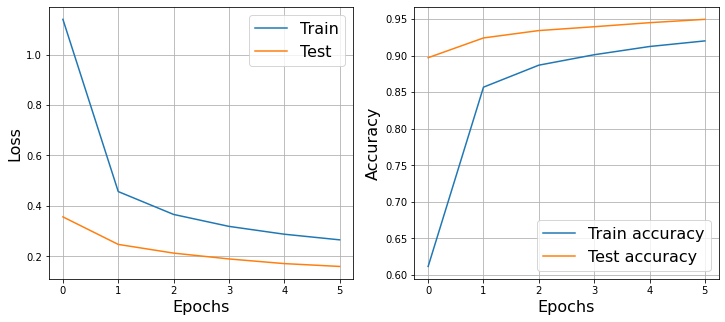

In [ ]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Точность с Dropout лучше, чем с DropConnect.

Точность на тесте значительно лучше, чем на тренировочных данных,
из-за зануления выходов нейрона при обучении и каждого веса по отдельности.


### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [18]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        output = self.alpha * (x - x.mean()) / (x.std() + 1e-8) +  self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [19]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
  layers.append(nn.Linear(size_input, size_output))
  layers.append(nn.BatchNorm1d(size_output))
  layers.append(nn.ReLU())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU()
3: Linear(in_features=128, out_features=128, bias=True)
4: BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5: ReLU()
6: Linear(in_features=128, out_features=10, bias=True)
7: BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.030/0.048	Accuracy: 0.993/0.986


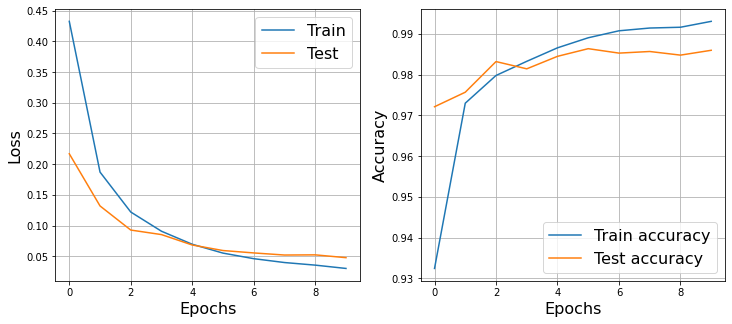

([0.43266129061611475,
  0.187115622513584,
  0.122056547043992,
  0.090750766651971,
  0.06954662906907515,
  0.05515381523461611,
  0.04608714403803033,
  0.0397955373958198,
  0.035565619462175665,
  0.030172223222257294],
 [0.21697152358821675,
  0.13196506653028198,
  0.09269780877836142,
  0.08530841032160988,
  0.06834562518928625,
  0.05934899984092652,
  0.055445997079810766,
  0.05201986306523786,
  0.05230064265123462,
  0.0477343861225851],
 [0.93244714,
  0.9729811,
  0.97977746,
  0.9832478,
  0.9865627,
  0.98902804,
  0.9907383,
  0.99141574,
  0.99161,
  0.99305373],
 [0.97211236,
  0.9756725,
  0.9831883,
  0.98140824,
  0.9844739,
  0.98635286,
  0.985265,
  0.9856606,
  0.9847706,
  0.98595726])

In [20]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [21]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
  layers.append(nn.Linear(size_input, size_output))
  layers.append(LayerNormalization(size_output))
  layers.append(nn.ReLU())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: LayerNormalization()
2: ReLU()
3: Linear(in_features=128, out_features=128, bias=True)
4: LayerNormalization()
5: ReLU()
6: Linear(in_features=128, out_features=10, bias=True)
7: LayerNormalization()


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.029/0.055	Accuracy: 0.992/0.984


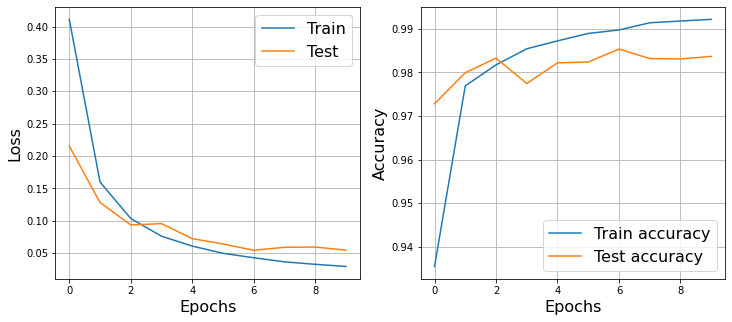

([0.4111099287645141,
  0.1597961330655287,
  0.10340042949231194,
  0.07602466665891441,
  0.06080981019113872,
  0.049656653105577174,
  0.04275911489028984,
  0.03639791705913699,
  0.03264590398843355,
  0.02934502219177608],
 [0.2153482731384567,
  0.12810428242517424,
  0.09350030539156515,
  0.09547543115442313,
  0.07226535312454158,
  0.06413473969301846,
  0.054364856415062765,
  0.05893535271899987,
  0.059315410654850395,
  0.05450912016809364],
 [0.93544555,
  0.97691786,
  0.9817264,
  0.98542994,
  0.98724014,
  0.9889504,
  0.9897499,
  0.99139905,
  0.99180436,
  0.9921875],
 [0.9728046,
  0.97992486,
  0.98328716,
  0.9774525,
  0.9821994,
  0.98239714,
  0.9853639,
  0.9831883,
  0.9830894,
  0.98368275])

In [22]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Точность с Batch normalization и Layer normalization не отличается друг от друга явно: в 2-х режимах наблюдается неустойчивость на тестовых данных.
